source: https://cloud.google.com/ml-engine/docs/tensorflow/python-guide

## Imports

In [107]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery

from pprint import pprint

In [97]:
# build a client object
ml = discovery.build('ml', 'v1')

In [3]:
!gcloud projects list

PROJECT_ID             NAME                           PROJECT_NUMBER
reliable-realm-222318  planetary-cargo-ship-detector  443054654239


In [100]:
PROJECT = 'reliable-realm-222318'

projectID = 'projects/{}'.format(PROJECT)

projectID

1. Make a request
2. Use the request

The client object acts as the root of the API, and each API path is accessed as a method path.

In [101]:
# List models
request = ml.projects().models().list(parent=projectID)

response = request.execute()

In [102]:
[model['name'] for model in response['models']]

['projects/reliable-realm-222318/models/mnist',
 'projects/reliable-realm-222318/models/satellite',
 'projects/reliable-realm-222318/models/satellite_transfer']

In [103]:
# List versions for a model
modelID = 'projects/reliable-realm-222318/models/satellite'
request = ml.projects().models().versions().list(parent=modelID)
response = request.execute()

In [104]:
response

{'versions': [{'name': 'projects/reliable-realm-222318/models/satellite/versions/v01',
   'isDefault': True,
   'deploymentUri': 'gs://reliable-realm-222318-mlengine/satellite_training_181121_133936/output/export/exporter/1542837757/',
   'createTime': '2018-11-21T22:05:43Z',
   'lastUseTime': '2018-11-22T04:44:13Z',
   'runtimeVersion': '1.10',
   'state': 'READY',
   'etag': 'rI7uXzFt2xM=',
   'framework': 'TENSORFLOW',
   'machineType': 'mls1-c1-m2',
   'pythonVersion': '3.5'}]}

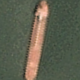

In [105]:
from PIL import Image, ImageDraw
from io import BytesIO
import base64

toy = Image.open('../../data/scenes/sfbay_1.png')

HEIGHT = 80
WIDTH = 80
DEPTH = 3
STEP = 10

l = 1640
t = 430
toy = toy.crop((l, t, l + WIDTH, t + HEIGHT))
clip1 = toy.copy()
clip1

In [68]:
# import base64, sys, json

# image = open('../../data/imgs/ship/1__20150830_000652_1_0b07__-122.32370681389538_37.72016772243502.png', 'rb')
# image_read = image.read()
# b64 = base64.b64encode(image_read)

In [70]:
# model_id = 'projects/reliable-realm-222318/models/satellite'

# # image_bytes = BytesIO()
# # clip1.save(image_bytes, format='PNG')
# # image_bytes = image_bytes.getvalue()

# body = {'image': {'image_bytes': b64}}

# request = ml.projects()
# request.predict(name=model_id, body=body)

In [75]:
def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

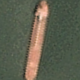

In [188]:
clip1

### Online Predictions from Python2 Base64

In [207]:
with open('../../tensorflow-cnn/satellite_model/request.json') as file:
    content = json.loads(file.read())

# content['key'] = '0001'
# content

In [191]:
request = ml.projects().predict(name='projects/reliable-realm-222318/models/satellite',
                                body={'instances': content}).execute()

In [192]:
pprint(request)

{'predictions': [{'class': 'no_ship',
                  'classid': 0,
                  'probabilities': [0.999603807926178,
                                    0.00039620129973627627]}]}


### Online Predictions from Python3 Base64

In [215]:
import base64
from io import BytesIO

model_id = 'projects/reliable-realm-222318/models/satellite'

image_bytes = BytesIO()
clip1.save(image_bytes, format='PNG')
image_bytes = image_bytes

body = {'instances': {'image_bytes': {'b64': base64.b64encode(image_bytes.getvalue()).decode()}}}

request = ml.projects()
response = request.predict(name=model_id, body=body).execute()
response

{'predictions': [{'class': 'ship',
   'probabilities': [0.0028550701681524515, 0.997144877910614],
   'classid': 1}]}

### Batch Predictions

#### Make Batch Job Body function

In [139]:
import time
import re

def make_batch_job_body(project_name, input_paths, output_path,
        model_name, region, data_format='JSON',
        version_name=None, max_worker_count=None,
        runtime_version=None):

    project_id = 'projects/{}'.format(project_name)
    model_id = '{}/models/{}'.format(project_id, model_name)
    if version_name:
        version_id = '{}/versions/{}'.format(model_id, version_name)

    # Make a jobName of the format "model_name_batch_predict_YYYYMMDD_HHMMSS"
    timestamp = time.strftime('%Y%m%d_%H%M%S', time.gmtime())

    # Make sure the project name is formatted correctly to work as the basis
    # of a valid job name.
    clean_project_name = re.sub(r'\W+', '_', project_name)

    job_id = '{}_{}_{}'.format(clean_project_name, model_name,
                           timestamp)

    # Start building the request dictionary with required information.
    body = {'jobId': job_id,
            'predictionInput': {
                'dataFormat': data_format,
                'inputPaths': input_paths,
                'outputPath': output_path,
                'region': region}}

    # Use the version if present, the model (its default version) if not.
    if version_name:
        body['predictionInput']['versionName'] = version_id
    else:
        body['predictionInput']['modelName'] = model_id

    # Only include a maximum number of workers or a runtime version if specified.
    # Otherwise let the service use its defaults.
    if max_worker_count:
        body['predictionInput']['maxWorkerCount'] = max_worker_count

    if runtime_version:
        body['predictionInput']['runtimeVersion'] = runtime_version

    return body

In [198]:
project_name = 'reliable-realm-222318'

# !gsutil ls gs://reliable-realm-222318-vcm/pipeline/batch_inputs
input_paths = ['gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request1.json',
               'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request2.json',
               'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request3.json']
# input_paths = ['gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request1.json']

output_path = 'gs://reliable-realm-222318-vcm/pipeline/batch_outputs'

model_name = 'satellite'

In [199]:
batch_predict_body = make_batch_job_body(project_name, 
                                         input_paths, 
                                         output_path,
                                         model_name,
                                         region='us-central1',
                                         data_format='JSON',
                                         version_name=None,
                                         max_worker_count=None,
                                         runtime_version=None)

# pprint(batch_predict_body['predictionInput']['outputPath'])
pprint(batch_predict_body)

{'jobId': 'reliable_realm_222318_satellite_20181122_175215',
 'predictionInput': {'dataFormat': 'JSON',
                     'inputPaths': ['gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request1.json',
                                    'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request2.json',
                                    'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request3.json'],
                     'modelName': 'projects/reliable-realm-222318/models/satellite',
                     'outputPath': 'gs://reliable-realm-222318-vcm/pipeline/batch_outputs',
                     'region': 'us-central1'}}


In [200]:
import googleapiclient.discovery as discovery
from googleapiclient import errors

project_id = 'projects/{}'.format(project_name)

ml = discovery.build('ml', 'v1')
request = ml.projects().jobs().create(parent=project_id,
                                      body=batch_predict_body)

try:
    response = request.execute()

    print('Job requested.')

    # The state returned will almost always be QUEUED.
    print('state : {}'.format(response['state']))

except errors.HttpError as err:
    # Something went wrong, print out some information.
    print('There was an error getting the prediction results.' +
          'Check the details:')
    print(err._get_reason())

Job requested.
state : QUEUED


## Monitor a job

In [201]:
request = ml.projects().jobs().list(parent=projectID)
response = request.execute()

In [202]:
[job for job in response['jobs'] if job['state'] == 'RUNNING']

[{'jobId': 'reliable_realm_222318_satellite_20181122_175215',
  'predictionInput': {'modelName': 'projects/reliable-realm-222318/models/satellite',
   'dataFormat': 'JSON',
   'inputPaths': ['gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request1.json',
    'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request2.json',
    'gs://reliable-realm-222318-vcm/pipeline/batch_inputs/request3.json'],
   'outputPath': 'gs://reliable-realm-222318-vcm/pipeline/batch_outputs',
   'region': 'us-central1',
   'runtimeVersion': '1.10'},
  'createTime': '2018-11-22T17:52:18Z',
  'startTime': '2018-11-22T17:52:18Z',
  'state': 'RUNNING',
  'predictionOutput': {'outputPath': 'gs://reliable-realm-222318-vcm/pipeline/batch_outputs'},
  'etag': 'ZyT2yaGMktQ='}]